Assuming we are solving document classification problem for a news article data set.\
We input each word, words relate to each other in some ways.\
We make predictions at the end of the article when we see all the words in that article.\
RNNs, by passing input from last output, are able to retain information, and able to leverage all information at the end to make predictions.

We are given a news article dataset and we have to classify them according to topics


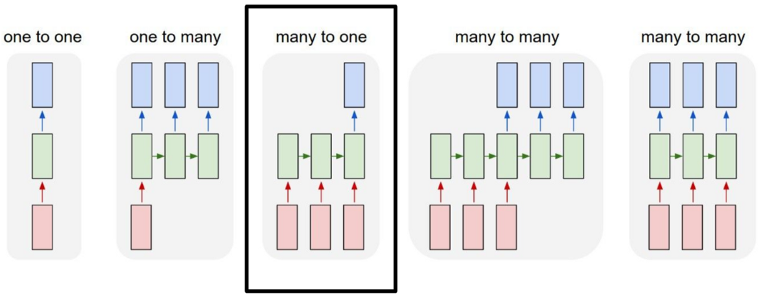

In our document classification for news article example, we have this many-to- one relationship. The input are sequences of words, output is one single class or label.

In [1]:
import csv
import pandas as pd
import string
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

2.2.0


### INTIALIZING THE VARIABLES

In [2]:
vocab_size = 5000
embedding_dim = 64
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .7

In [3]:
labels=list(pd.read_csv("bbc_text.csv")["category"].values)
article=list(pd.read_csv("bbc_text.csv")["text"].values)
len(labels)

2225

In [4]:
len(labels)==len(article)

True

In [5]:
articles=[]

for row in article:
    sent=[]
    for word in row.split(" "):
        if word not in STOPWORDS:
            sent.append(word.strip(string.punctuation))
    articles.append(" ".join(sent).replace("  "," "))

There are 2,225 news articles in the data, we split them into training set and validation set, according to the parameter we set earlier, 80% for training, 20% for validation.

### SPLITTING THE TRAIN/VALID/TEST

In [6]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

validation_articles = articles[train_size:-100]
validation_labels = labels[train_size:-100]

test_articles=articles[-100:]
test_labels=labels[-100:]

print(train_size)
print(len(train_articles))
print(len(train_labels))
print(len(validation_articles))
print(len(validation_labels))
print (len(test_articles))
print (len(test_labels))

1557
1557
1557
568
568
100
100


Tokenizer does all the heavy lifting for us. In our articles that it was tokenizing, it will take 5,000(vocab_size) most common words. oov_token is to put a special value in when an unseen word is encountered. This means we want <OOV> to be used for words that are not in the word_index. fit_on_text will go through all the text and create dictionary like this:


In [7]:
#ref https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'said': 2,
 'mr': 3,
 'would': 4,
 'year': 5,
 'also': 6,
 'people': 7,
 'new': 8,
 'us': 9,
 'one': 10}

0 is a reserved index that won't be assigned to any word.

In [8]:
len(word_index)

25921

After tokenization, the next step is to turn those tokens into lists of sequence. The following is the 15th article in the training data that has been turned into sequences.

In [9]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# METHOD FOR DECODING THE TEXT ARTICLE

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

### EXPLORING THE OUPUT OF TOKENIZATION

In [10]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
print(train_sequences[14])

[2303, 3959, 1090, 247, 59, 3625, 2303, 1120, 985, 1090, 247, 409, 3197, 564, 435, 927, 1573, 91, 3336, 954, 1, 2303, 24, 1497, 985, 657, 409, 344, 1574, 1573, 71, 43, 158, 71, 158, 33, 158, 71, 158, 100, 190, 3463, 1, 77, 33, 319, 1, 28, 1, 1, 126, 2, 2303, 686, 2085, 431, 3091, 431, 65, 456, 1620, 985, 1090, 247, 406, 167, 16, 19, 348, 1, 435, 832, 2303, 1, 1, 791, 1090, 247, 2973, 774, 3207, 1, 7, 2, 4906, 65, 198, 41, 2697, 894, 1652, 4906, 156, 2878, 25, 372, 400, 156, 302, 1029, 820, 1, 1, 2, 1, 248, 165, 29, 795, 518, 9, 1601, 257, 34, 228, 1573, 126, 435, 794, 1258, 19, 663, 985, 409, 6, 4147, 360, 3337, 3789, 435, 1573, 587, 1346, 1762, 433, 19, 1, 275, 1, 743, 1, 207, 59, 1090, 247, 165, 41, 1575, 5, 2, 3789, 3623, 9, 391, 3333, 1, 561, 1573, 851, 143, 72, 1763, 3626, 1, 1565, 4350, 65, 146, 2791, 94, 1197, 251, 1545, 2532, 4596, 421, 295, 774, 72, 295, 774, 1, 1, 198, 1571, 1, 69, 51, 161, 237, 3627, 3626, 3628, 1145, 65, 101, 54, 2698, 14, 72, 986, 1546, 72, 2791, 21, 1982,

In [11]:
decode_review(train_sequences[14])

'moya emotional davis cup win carlos moya described spain davis cup victory highlight career beat andy roddick end usa challenge <OOV> moya made missing spain 2000 victory injury beating roddick 6 2 7 6 7 1 7 6 7 5 give hosts <OOV> 3 1 lead <OOV> many <OOV> <OOV> day said moya energy focused today lived today think live again spain davis cup title came two years ago <OOV> beat australia moya <OOV> <OOV> admitted davis cup dream bit nervous <OOV> people said obsessed think better way helps reach goals obsessed really incredible get winning point really something spanish captain <OOV> <OOV> said <OOV> played great game opportunity let us down lost three times roddick day beat him waiting years position spain victory also remarkable performance rafael nadal beat roddick opening singles aged 18 years <OOV> days <OOV> became <OOV> player win davis cup great way finish year said nadal afterwards us coach patrick <OOV> wants roddick rest team play tennis clay <OOV> skills surface think help g

In [12]:
articles[14]

'moya emotional davis cup win carlos moya described spain davis cup victory highlight career beat andy roddick end usa challenge seville moya made missing spain 2000 victory injury beating roddick 6-2 7-6 7-1 7-6 7-5 give hosts unassailable 3-1 lead woken many nights dreaming day  said moya energy focused today lived today think live again spain davis cup title came two years ago valencia beat australia moya nicknamed charly admitted davis cup dream bit nervous outset people said obsessed think better way helps reach goals obsessed really incredible get winning point really something spanish captain jordi arrese said charly played great game opportunity let us down lost three times roddick day beat him waiting years position spain victory also remarkable performance rafael nadal beat roddick opening singles aged 18 years 185 days mallorcan became youngest player win davis cup great way finish year  said nadal afterwards us coach patrick mcenroe wants roddick rest team play tennis clay 

### PADDING

When we train neural networks for NLP, we need sequences to be in the same size, that’s why we use padding. If you look up, our max_length is 300, so we use pad_sequences to make all of our articles the same length which is 300. As a result, you will see that the 1st article was 411 in length, it becomes 200, the 2nd article was 191 in length, it becomes 300, and so on.

In [13]:
len(max(articles,key=len).split(" "))

2273

In [14]:
len(articles[1].split())

191

In [15]:
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

425
300
192
300
186
300


In addition, there is padding_type and truncating_type, there are all post, means for example, for the 11th article, it was 186 in length, we padded to 200, and we padded at the end, that is adding 14 zeros.

Then we do the same for the validation sequences.

In [16]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

568
(568, 300)


In [17]:
test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(test_sequences))
print(test_padded.shape)

100
(100, 300)


Now we are going to look at the labels. Because our labels are text, so we will tokenize them, when training, labels are expected to be numpy arrays. So we will turn list of labels into numpy arrays like so:

In [28]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq=np.array(label_tokenizer.texts_to_sequences(test_labels))
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

[4]
[2]
[1]
(1557, 1)
[1]
[1]
[5]
(568, 1)


### MODELLING

Now its the time to implement LSTM.

In [19]:
set(labels)

{'business', 'entertainment', 'politics', 'sport', 'tech'}

 - We build a tf.keras.Sequential model and start with an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices into sequences of vectors. After training, words with similar meanings often have the similar vectors.
 - The Bidirectional wrapper is used with a LSTM layer, this propagates the input forwards and backwards through the LSTM layer and then concatenates the outputs. This helps LSTM to learn long term dependencies. We then fit it to a dense neural network to do classification.
 - We use relu in place of tahn function since they are very good alternatives of each other.
 - We add a Dense layer with 6 units and softmax activation. When we have multiple outputs, softmax converts outputs layers into a probability distribution.

In [20]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 394,694
Trainable params: 394,694
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 8
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/8
49/49 - 17s - loss: 1.6194 - accuracy: 0.2588 - val_loss: 1.3521 - val_accuracy: 0.5158
Epoch 2/8
49/49 - 15s - loss: 1.0290 - accuracy: 0.6390 - val_loss: 1.0874 - val_accuracy: 0.6092
Epoch 3/8
49/49 - 15s - loss: 0.5337 - accuracy: 0.8638 - val_loss: 0.4102 - val_accuracy: 0.8556
Epoch 4/8
49/49 - 14s - loss: 0.1248 - accuracy: 0.9743 - val_loss: 0.2503 - val_accuracy: 0.9243
Epoch 5/8
49/49 - 13s - loss: 0.0244 - accuracy: 0.9968 - val_loss: 0.2635 - val_accuracy: 0.9366
Epoch 6/8
49/49 - 14s - loss: 0.0136 - accuracy: 0.9974 - val_loss: 0.2626 - val_accuracy: 0.9190
Epoch 7/8
49/49 - 13s - loss: 0.0096 - accuracy: 0.9987 - val_loss: 0.2253 - val_accuracy: 0.9489
Epoch 8/8
49/49 - 15s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.2375 - val_accuracy: 0.9472


### PREDICTING ON TEST DATA

In [26]:
np.argmax(model.predict(test_padded) > 0.5,axis=1)

array([3, 3, 1, 2, 2, 4, 2, 4, 4, 1, 2, 3, 1, 2, 2, 1, 4, 1, 4, 5, 1, 1,
       5, 2, 4, 1, 1, 3, 4, 2, 3, 1, 1, 3, 2, 4, 4, 2, 2, 1, 5, 2, 4, 2,
       3, 4, 1, 1, 4, 4, 3, 2, 1, 5, 3, 1, 5, 4, 1, 2, 2, 2, 1, 1, 4, 1,
       2, 4, 2, 2, 1, 2, 3, 2, 2, 4, 3, 4, 3, 4, 5, 3, 4, 5, 1, 3, 5, 2,
       4, 2, 4, 5, 4, 1, 2, 2, 3, 5, 3, 1], dtype=int64)

In [33]:
sum(test_label_seq.flatten('C')==np.argmax(model.predict(test_padded) > 0.5,axis=1))

94

Accuracy on test data is 94%